The purpose of this notebook is to understand how the `randomise` algorithm works with a simple simulation.

1. Generate data for two nodes ($y_1, y_2$)   
using two inputs ($x_1, x_2$)   
that stimulates each node respectively ($\beta_{1,1} > 0, \beta_{2,1} = 0, \beta_{1,2} = 0, \beta_{2,2} > 0$) 

2. Regress $y_1, y_2$ on $x_1, x_2$ to get observed test statistics in the data

3. Create empirical null for the test stat for each regressor in each node. 
    - For each permutation: Regress out "nuisance" variable
    - Regress residuals on the *shuffled* regressor of interest
    - Extract test stat 
    
4. Compute empirical null for each regressor using the max test stat from both nodes
    - Compute the critical test stat for each regressor based on this empirical null informed by the whole image  

5. Compute corrected p-values: What proportion of test stats in the empirical null are larger than the observed test stat

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nilearn.glm.first_level import make_first_level_design_matrix, spm_hrf
import pandas as pd
import seaborn as sns
import random

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
def events_to_timeseries(frame_times, events, label = 'stim', hrf_model = 'spm'):
    
    if hrf_model is not None:
        events['trial_type']=label
    
    # Note I'm not making a design matrix per se here. Just using the function as convenience to make the timeseries from onsets, durations and amplitudes
    ts = make_first_level_design_matrix(frame_times, events, drift_model=None, hrf_model = hrf_model)
    ts['label'] = label
    ts = ts.rename(columns={label:'amplitude'})
    ts = ts[['label', 'amplitude']]
    ts['time'] = ts.index
    
    return ts

Block task with varying amplitude

In [21]:
tr = 1.0
nscans = 1000
frame_times = np.arange(nscans) * tr

In [28]:
onsets = np.arange(20, nscans, 20)
durations = np.array([3]*len(onsets))
amplitudes = np.random.normal(loc=1, scale=.5, size=len(onsets))
x1_events = pd.DataFrame({'onset': onsets, 'duration': durations, 'trial_type': 'x1', 'modulation': amplitudes})
x1 = events_to_timeseries(frame_times, x1_events, label = 'x1', hrf_model = None)
x1_conv = events_to_timeseries(frame_times, x1_events, label = 'x1_conv', hrf_model = 'spm')

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


In [34]:
onsets = onsets + 10
durations = np.array([3]*len(onsets))
amplitudes = np.random.normal(loc=1, scale=.5, size=len(onsets))
x2_events = pd.DataFrame({'onset': onsets, 'duration': durations, 'trial_type': 'x2', 'modulation': amplitudes})
x2 = events_to_timeseries(frame_times, x2_events, label = 'x2', hrf_model = None)
x2_conv = events_to_timeseries(frame_times, x2_events, label = 'x2_conv', hrf_model = 'spm')

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


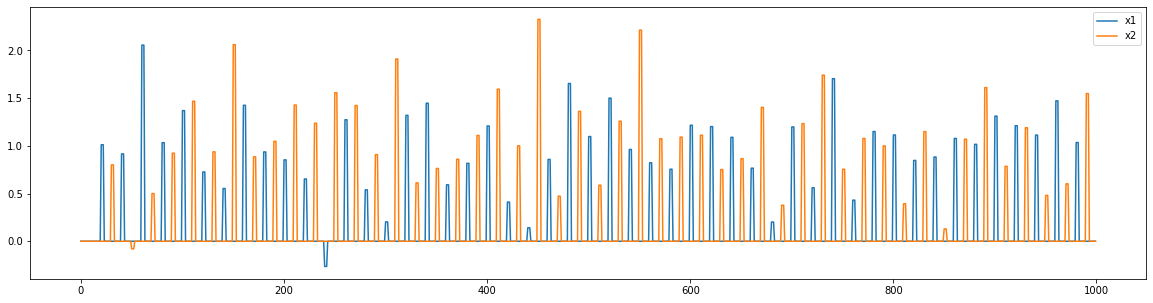

In [45]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
plt.plot(x1['amplitude'], label="x1")
plt.plot(x2['amplitude'], label="x2")
plt.legend()

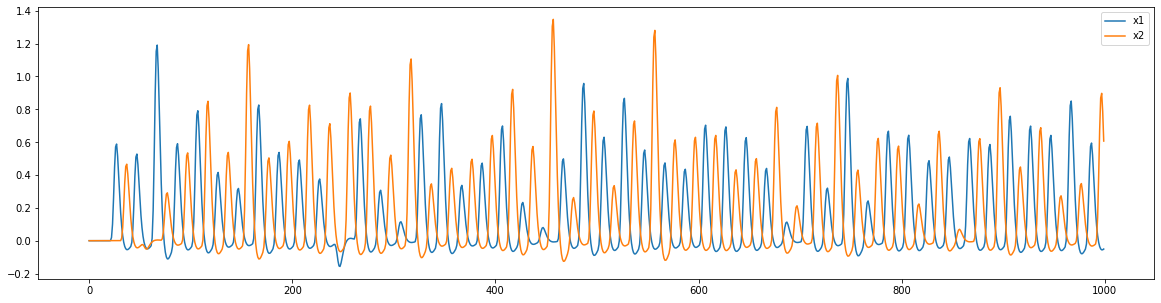

In [46]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
plt.plot(x1_conv['amplitude'], label="x1")
plt.plot(x2_conv['amplitude'], label="x2")
plt.legend()

In [43]:
b1_1 = 2
b2_1 = 0.1
y1_conv = (b1_1*x1_conv['amplitude']) + (b2_1*x2_conv['amplitude'])+ np.random.normal(loc=0, scale=.5, size=nscans)

In [44]:
b1_2 = 0.1
b2_2 = 1.5
y2_conv = (b1_2*x1_conv['amplitude']) + (b2_2*x2_conv['amplitude'])+ np.random.normal(loc=0, scale=.5, size=nscans)

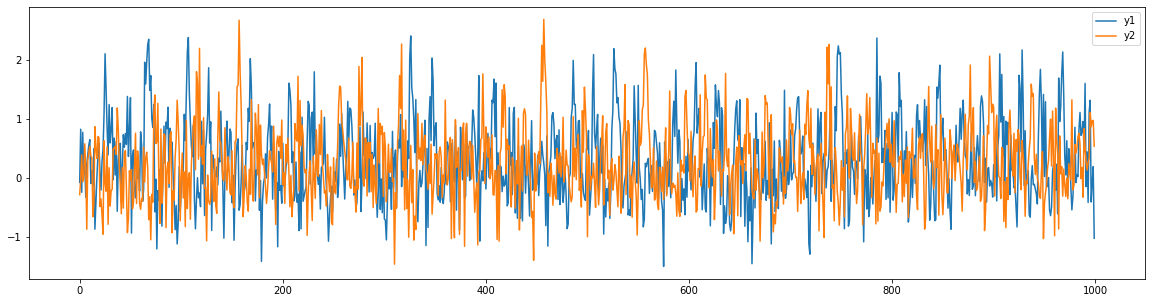

In [47]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
plt.plot(y1_conv, label="y1")
plt.plot(y2_conv, label="y2")
plt.legend()